### Experiment 2 - Table 2

Calculating test accuracy and robustness (adversarial accuracy, adv. acc) for different datasets and different settings, given Trimmed mean and median aggregation schemes

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from utils.util_notebooks import set_args, import_model_weights, get_adv_acc
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

def calc_atk_model(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_inject)
    inject_state_dict = model_inject.state_dict(keep_vars=False)
    global_state_dict = model_global.state_dict(keep_vars=False)
    return_state_dict = atk_model.state_dict(keep_vars=False)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
    # for key in inject_state_dict.keys():
        # print(key, "total")
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    atk_model.load_state_dict(return_state_dict)

    return atk_model

def undo_calc_atk_model(atk_model, model_global, keys, weight_scale, weight_scale_2):
    """
    Reverses the `calc_atk_model` process to find `model_inject` from `atk_model` and `model_global`.
    
    Args:
        atk_model (torch.nn.Module): The attacker model generated from `calc_atk_model`.
        model_global (torch.nn.Module): The global model used in `calc_atk_model`.
        keys (list of str): The keys of the state dictionary to process.
        weight_scale (float): Weight scale factor used in `calc_atk_model`.
        weight_scale_2 (float): Second weight scale factor used in `calc_atk_model`.
    
    Returns:
        torch.nn.Module: The reconstructed `model_inject`.
    """
    model_inject = copy.deepcopy(model_global)
    atk_state_dict = atk_model.state_dict(keep_vars=False)
    global_state_dict = model_global.state_dict(keep_vars=False)
    inject_state_dict = model_inject.state_dict(keep_vars=False)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
        # Reverse the operation to calculate the original inject_state_dict
        diff = (atk_state_dict[key].data.clone() - global_state_dict[key].data.clone()) / total_weight
        inject_state_dict[key].data = diff + global_state_dict[key].data.clone()

    model_inject.load_state_dict(inject_state_dict)

    return model_inject

# Clone data from attack model to client model
def clone_model_weights(model_source, model_target, keys):
    target_state_dict = model_target.state_dict(keep_vars=True)
    source_state_dict = model_source.state_dict(keep_vars=True)
    
    for key in keys:
        target_state_dict[key].data = source_state_dict[key].data.clone()

    return

# Expand aggregator.mix() function
def UNL_mix(aggregator, adv_id, model_inject, keys, weight_scale_2, dump_flag=False, aggregation_op = None, tm_beta = 0.05, median_threshold = None):
    weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    # if aggregation_op == None:
    #     aggregation_op = aggregator.aggregation_op
        
    # Based on aggregation methods change weight scale
    if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
        weight_scale = np.ones(weight_scale.shape)

    if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
        N_removed = int(tm_beta*len(aggregator.clients))
        weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
        print("trimmed mean, N removed: ", N_removed)
        print("weight scale: \n", weight_scale)

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))

    for a_id in adv_id:
        benign_id.remove(a_id)
        temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
        aggregator.clients[a_id].learners_ensemble[0].model.cpu()
        del aggregator.clients[a_id].learners_ensemble[0].model
        aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model.cuda()
        del temp_atk_model
        gc.collect()
        torch.cuda.empty_cache()

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'median_sublayers':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median_sublayers.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median_with_threshold(
                learners, 
                learner, 
                threshold = median_threshold,
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    return 

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 121.11it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:16<00:00,  2.50it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [20]:
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregation_op = 'trimmed_mean'
aggregator.op = aggregation_op
weight_scale_2 = 1
atk_rounds = 1
tm_beta = 0
adv_id = [0]

model_inject = model_Fedavg
keys = desired_keys

################################# Code starts here

weight_scale = 1/aggregator.clients_weights
model_global = aggregator.global_learners_ensemble[0].model

# if aggregation_op == None:
#     aggregation_op = aggregator.aggregation_op
    
# Based on aggregation methods change weight scale
if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
    weight_scale = np.ones(weight_scale.shape)

if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
    N_removed = int(tm_beta*len(aggregator.clients))
    weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
    print("trimmed mean, N removed: ", N_removed)
    print("weight scale: \n", weight_scale)

# Give adversarial clients boosted models and train regular clients 1 round
benign_id = list(range(len(aggregator.clients)))

for a_id in adv_id:
    benign_id.remove(a_id)
    temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)

for c_id in benign_id:
    aggregator.clients[c_id].step()

learner_id = 0
global_learner = aggregator.global_learners_ensemble[learner_id]
learners =  [client.learners_ensemble[learner_id] for client in [aggregator.clients[i] for i in benign_id]]
adjusted_weights = torch.from_numpy((1/weight_scale)[benign_id] / np.sum( (1/weight_scale)[benign_id]))
average_learners(learners, global_learner, weights=adjusted_weights)

model_global_updated = aggregator.global_learners_ensemble[0].model

############# - Unmix temp atk model - ###########
reverse_model = undo_calc_atk_model(temp_atk_model, model_global_updated, keys, weight_scale[a_id], weight_scale_2)


/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(torch.load(chkpts_path))


trimmed mean, N removed:  0
weight scale: 
 [40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00]


Layer Name                                            Cosine Similarity
                                                                    nan 
features                                                            nan 
features.0                                                   0.99988079 
features.0.0                                                 0.99996156 
features.0.1                                                 0.99983197 
features.0.2                                                 0.99988079 
features.1                                                   0.99956816 
features.1.conv                                              0.99956816 
features.1.conv.0                                            0.99991351 
features.1.conv.0.0                                          0.99988216 
features.1.conv.0.1                                          0.99990386 
features.1.conv.0.2                                          0.99991351 
features.1.conv.1                                   

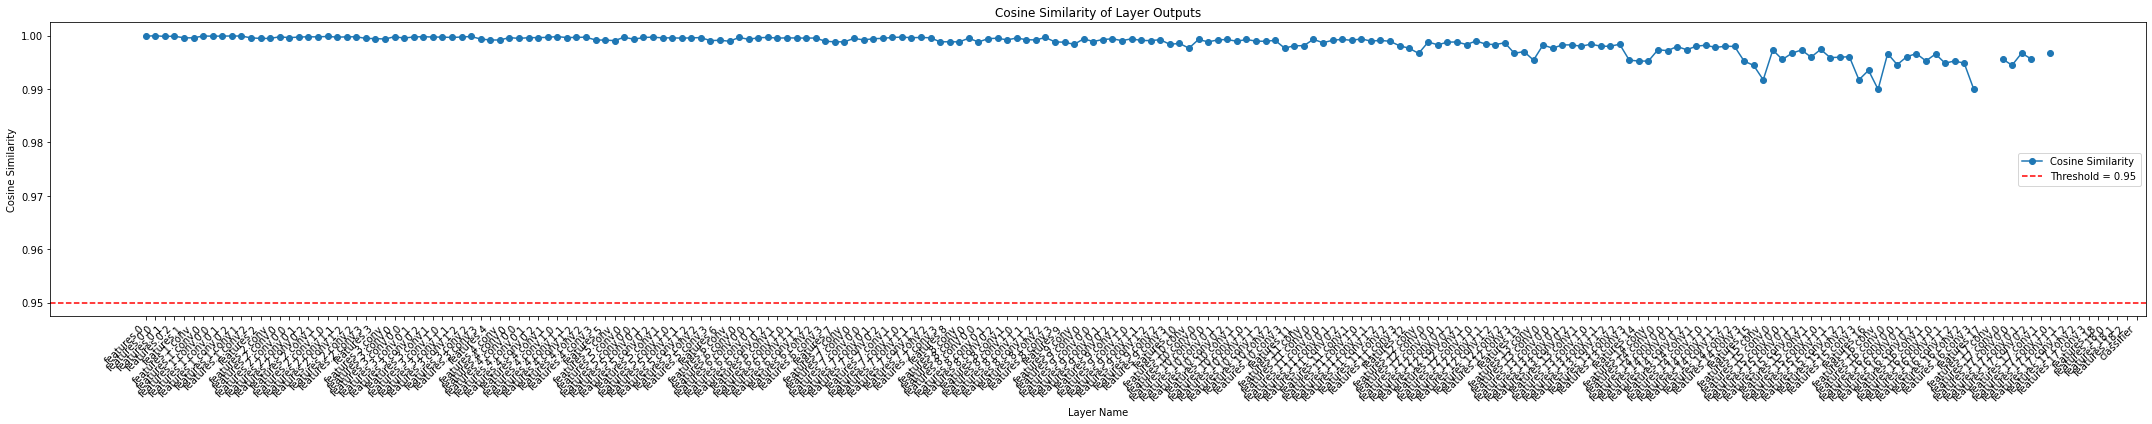

In [24]:
dataloader = load_client_data(clients = aggregator.clients, c_id = 0, mode = 'test')
x_data = dataloader.x_data
y_data = dataloader.y_data
# Example usage
_ = compare_layer_outputs_with_cosine_similarity(model_Fedavg, reverse_model, x_data.cuda())

In [25]:
# Take measurement for ARU attack
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregation_op = 'trimmed_mean'
aggregator.op = aggregation_op
weight_scale_2 = 1
atk_rounds = 1
tm_beta = 0

if False:
    print("updating adv data set")

    # add adv dataset update
    Fu = np.ones(num_user) * 0.5

    # Setting evasion attack parameters
    x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
    x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = steps,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = step_size, step_norm = "inf", eps = eps_train, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(aggregator.clients)):
        if Fu[c] > 0:
            # print (c)
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()

            aggregator.clients[c].assign_advdataset()


for i in range(atk_rounds):
    print('round ', i)
    UNL_mix(aggregator, adv_id=[0], model_inject=model_FAT, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op, tm_beta = tm_beta)


model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("TRIMMED MEAN")
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
trimmed mean, N removed:  0
weight scale: 
 [40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00]
TRIMMED MEAN
Test acc:  0.10687500080093741  ( 0.07261574788206224 )  adv acc:  0.10687500080093741  ( 0.07261574788206224 ) 


Layer Name                                            Cosine Similarity
                                                                    nan 
features                                                            nan 
features.0                                                          nan 
features.0.0                                                        nan 
features.0.1                                                        nan 
features.0.2                                                        nan 
features.1                                                          nan 
features.1.conv                                                     nan 
features.1.conv.0                                                   nan 
features.1.conv.0.0                                                 nan 
features.1.conv.0.1                                                 nan 
features.1.conv.0.2                                                 nan 
features.1.conv.1                                   

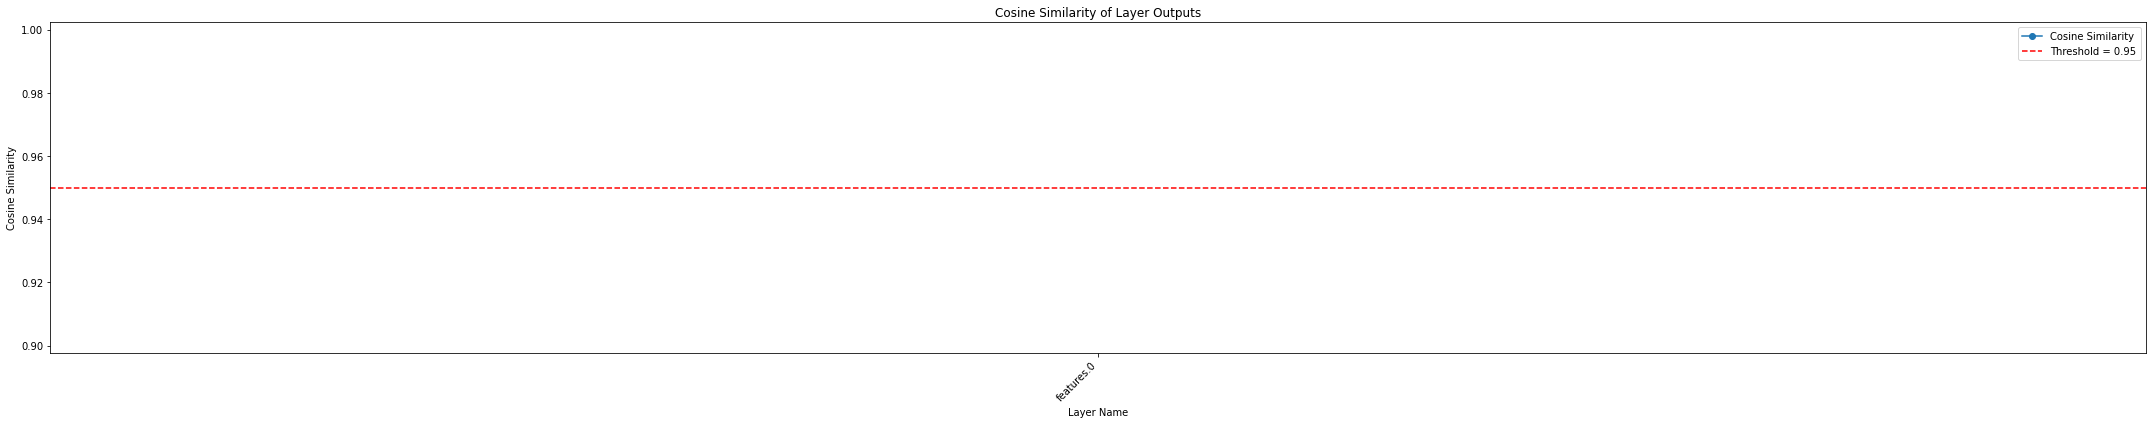

In [26]:
dataloader = load_client_data(clients = aggregator.clients, c_id = 0, mode = 'test')
x_data = dataloader.x_data
y_data = dataloader.y_data
# Example usage
_ = compare_layer_outputs_with_cosine_similarity(model_Fedavg, model_overfit, x_data.cuda())

In [34]:
model_overfit.state_dict()['features.0.1.weight']

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')

In [ ]:
model_overfit

In [ ]:
# Take measurement for ARU attack
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregator.op = None
weight_scale_2 = 1
atk_rounds = 1
aggregation_op = 'median'

for i in range(atk_rounds):
    print('round ', i)
    UNL_mix(aggregator, adv_id=[0], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op)

model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("MEDIAN")
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
